## Observations and Insights 

1. The linear regression model shows a positive correlation between the weight of the mouse and the average tumor volume in animals treated with Capomulin. 
2. Treatment with either Capomulin or Ramicane provideded the largest reduction in tumor volume. 
3. Mouse s185, which was treated with Capomodulin, showed ~50% reduction in tumor volume after 45 days of treatment. 

## Import and Clean Data

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import linregress

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

#Combine the data into a single dataset
mousedata_combined = mouse_metadata.merge(study_results, how="outer", on="Mouse ID")

# Display the data table for preview
mousedata_combined.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [2]:
# Number of unique mice in the study.
mousedata_combined["Mouse ID"].nunique()


249

In [3]:
# Identify duplicates for Mouse ID and Timepoint. 
mousedata_duplicates = mousedata_combined[mousedata_combined.duplicated(subset=["Mouse ID","Timepoint"], keep=False)]
mousedata_duplicates.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0


In [4]:
mousedata_duplicates["Mouse ID"].nunique()

1

In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
drop_mouse = mousedata_combined[mousedata_combined["Mouse ID"] == "g989"].index
mousedata_clean = mousedata_combined.drop(drop_mouse)
mousedata_clean.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [6]:
# Verify that the number of mice in the clean DataFrame is one less than the combined dataframe.
mousedata_clean["Mouse ID"].nunique()

248

## Summary Statistics

In [7]:
# Generate a summary statistics table of mean, median, variance, standard deviation, 
# and SEM of the tumor volume for each regimen.
drug_df = mousedata_clean.groupby(["Drug Regimen"])

#Summary Stats
mean = drug_df["Tumor Volume (mm3)"].mean()
median = drug_df["Tumor Volume (mm3)"].median()
variance = drug_df["Tumor Volume (mm3)"].var()
std = drug_df["Tumor Volume (mm3)"].std()
sem = drug_df["Tumor Volume (mm3)"].sem()

#Move summary stats into a new dataframe
drug_stats = pd.DataFrame({
    "Mean":mean,
    "Median":median,
    "Variance":variance,
    "Std. Dev.":std,
    "SEM":sem
})

#Display new dataframe
drug_stats

,Mean,Median,Variance,Std. Dev.,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [8]:
# Using the aggregation method, produce the same summary statistics in a single line
drug_df.agg({"Tumor Volume (mm3)": ["mean", "median", "var", "std", "sem"]})

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

## Bar and Pie Charts

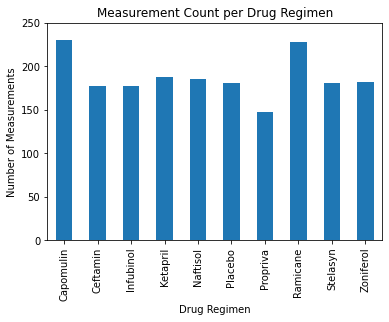

In [9]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pandas.
measurement_count = drug_df["Drug Regimen"].count()

drug_barchart = measurement_count.plot(kind="bar", title="Measurement Count per Drug Regimen")
drug_barchart.set_xlabel("Drug Regimen")
drug_barchart.set_ylabel("Number of Measurements")
plt.ylim(0, 250)
plt.show()

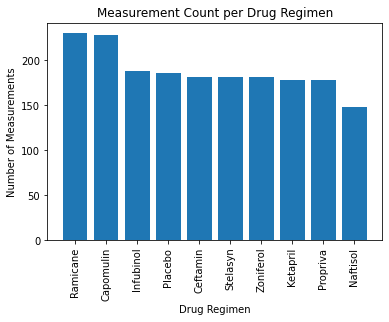

In [10]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.
drug = mousedata_clean["Drug Regimen"].unique()
measurements = mousedata_clean["Drug Regimen"].value_counts()

plt.bar(drug, measurements)
plt.title("Measurement Count per Drug Regimen")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Measurements")
plt.xticks(rotation=90)
plt.show()

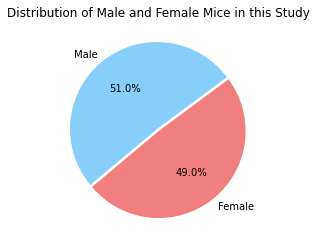

In [11]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
gender_df = mousedata_clean.groupby("Sex")
gender_count = gender_df["Sex"].count()

gender_piechart = gender_count.plot(kind="pie", title="Distribution of Male and Female Mice in this Study", 
                                    autopct = "%.1f%%", colors = ['lightcoral', 'lightskyblue'], startangle=220, 
                                    use_index=False, explode=[0,0.03])
gender_piechart.set_ylabel('')
plt.show()

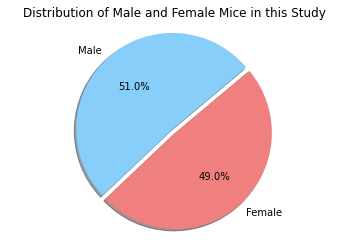

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
mouse_gender = mousedata_clean["Sex"].value_counts()
gender = ["Male", "Female"]
colors = ["lightskyblue", "lightcoral"]
explode = [0, 0.05]

plt.pie(mouse_gender, explode=explode, labels=gender, colors=colors, autopct="%1.1f%%", shadow=True, startangle=40)
plt.title("Distribution of Male and Female Mice in this Study")
plt.axis("equal")
plt.show()

## Quartiles, Outliers and Boxplots

In [13]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
max_timepoint_merged = pd.DataFrame(mousedata_clean.groupby("Mouse ID")["Timepoint"].max().sort_values()).rename(columns={"Timepoint":"Max_Timepoint"})

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
max_timepoint_merged = pd.merge(mousedata_clean, max_timepoint_merged, on='Mouse ID')
max_timepoint_merged

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Max_Timepoint
0,k403,Ramicane,Male,21,16,0,45.000000,0,45
1,k403,Ramicane,Male,21,16,5,38.825898,0,45
2,k403,Ramicane,Male,21,16,10,35.014271,1,45
3,k403,Ramicane,Male,21,16,15,34.223992,1,45
4,k403,Ramicane,Male,21,16,20,32.997729,1,45
...,...,...,...,...,...,...,...,...,...
1875,z969,Naftisol,Male,9,30,25,63.145652,2,45
1876,z969,Naftisol,Male,9,30,30,65.841013,3,45
1877,z969,Naftisol,Male,9,30,35,69.176246,4,45
1878,z969,Naftisol,Male,9,30,40,70.314904,4,45


In [14]:
# Put treatments into a list for for loop (and later for plot labels)
drugs = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]  

# Create empty list to fill with tumor vol data (for plotting)
tumor_volume = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
    # Locate the rows which contain mice on each drug and get the tumor volumes
for drug in drugs:
    four_drugs = max_timepoint_merged.loc[max_timepoint_merged["Drug Regimen"] == drug]
    
    # Create a dataframe that only contains the rows with final volumes 
    final_tumor_volume = four_drugs.loc[four_drugs["Timepoint"] == four_drugs["Max_Timepoint"]]
    volume = final_tumor_volume["Tumor Volume (mm3)"]
    tumor_volume.append(volume)
    
    # Calculate the quartiles
    quartiles = volume.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = round(upperq-lowerq, 6)
    print(f"{drug}")
    print(f'Inner Quartile Range for {drug}: {iqr}')
    
    # Find upper and lower bounds to help identify outliers for each regimen
    lower_bound = round(lowerq - (1.5*iqr), 6)
    upper_bound = round(upperq + (1.5*iqr), 6)
    print(f'Lower Bound for {drug}: {lower_bound}')
    print(f'Upper Bound for {drug}: {upper_bound}')
    
    # Determine outliers using upper and lower bounds
    outliers = (volume.loc[(final_tumor_volume["Tumor Volume (mm3)"] >= upper_bound) | 
                                        (final_tumor_volume["Tumor Volume (mm3)"] <= lower_bound)]).count()
    print(f'Number of {drug} outliers: {outliers}')
    print("-----------------------------------------------")

Capomulin
Inner Quartile Range for Capomulin: 7.781863
Lower Bound for Capomulin: 20.704562
Upper Bound for Capomulin: 51.832015
Number of Capomulin outliers: 0
-----------------------------------------------
Ramicane
Inner Quartile Range for Ramicane: 9.098537
Lower Bound for Ramicane: 17.912664
Upper Bound for Ramicane: 54.306812
Number of Ramicane outliers: 0
-----------------------------------------------
Infubinol
Inner Quartile Range for Infubinol: 11.477135
Lower Bound for Infubinol: 36.832905
Upper Bound for Infubinol: 82.741445
Number of Infubinol outliers: 1
-----------------------------------------------
Ceftamin
Inner Quartile Range for Ceftamin: 15.577752
Lower Bound for Ceftamin: 25.35545
Upper Bound for Ceftamin: 87.666458
Number of Ceftamin outliers: 0
-----------------------------------------------


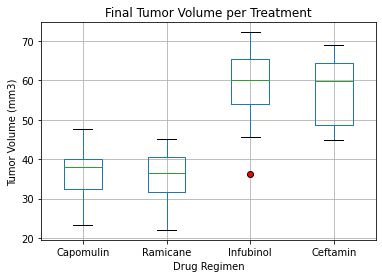

In [15]:
four_drugs_df = pd.DataFrame({
    "Capomulin": [23.343598, 28.484033, 28.430964, 30.485985, 31.023923, 31.896238, 32.377357, 33.329098,
                34.455298, 37.311846, 36.041047, 37.074024, 38.846876, 38.939633, 38.982878, 38.753265,
                38.125164, 39.952347, 40.658124, 40.159220, 40.728578, 41.483008, 41.581521, 47.685963, 46.539206],
    "Ramicane": [22.050126, 29.128472, 30.276232, 30.564625, 30.638696, 31.560470, 31.095335, 33.397653, 32.978522,
                33.562402, 36.134852, 38.810366, 37.225650, 36.374510, 36.561652, 37.311236, 38.342008, 38.407618,
                40.659006, 40.667713, 45.220869, 43.047543, 43.419381, 43.166373, 44.183451],
    "Infubinol": [67.973419, 65.525743, 57.031862, 66.083066, 72.226731, 36.321346, 60.969711, 62.435404, 60.918767,
                67.289621, 66.196912, 62.117279, 47.010364, 60.165180, 55.629428,  45.699331, 54.656549, 55.650681,
                46.250112, 54.048608, 51.542431, 50.005138, 58.268442, 67.685569, 62.754451],
    "Ceftamin": [62.999356, 45.000000, 56.057749, 55.742829, 48.722078, 47.784682, 61.849023, 68.923185, 67.748662, 
                57.918381, 46.784535, 59.851956, 64.299830, 59.741901, 61.433892, 64.192341, 45.000000, 52.925348,
                45.000000, 67.527482, 45.000000, 64.634949, 61.386660, 68.594745, 64.729837]
})

# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
red_circle = dict(markerfacecolor="r", marker="o")
boxplot = four_drugs_df.boxplot(column=["Capomulin","Ramicane","Infubinol","Ceftamin"], flierprops=red_circle)
boxplot.set_title("Final Tumor Volume per Treatment")
boxplot.set_xlabel("Drug Regimen")
boxplot.set_ylabel("Tumor Volume (mm3)")
plt.show()

## Line and Scatter Plots

In [16]:
# Identify a mouse treated with Capomulin to use for analysis
capo_mouse = mousedata_clean.loc[mousedata_clean["Drug Regimen"] == "Capomulin"]
capo_mouse.head(10)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
10,s185,Capomulin,Female,3,17,0,45.000000,0
11,s185,Capomulin,Female,3,17,5,43.878496,0
12,s185,Capomulin,Female,3,17,10,37.614948,0
13,s185,Capomulin,Female,3,17,15,38.177232,0
14,s185,Capomulin,Female,3,17,20,36.866876,0
15,s185,Capomulin,Female,3,17,25,33.949940,0
16,s185,Capomulin,Female,3,17,30,32.959671,1
17,s185,Capomulin,Female,3,17,35,28.328531,1
18,s185,Capomulin,Female,3,17,40,25.472143,1
19,s185,Capomulin,Female,3,17,45,23.343598,1


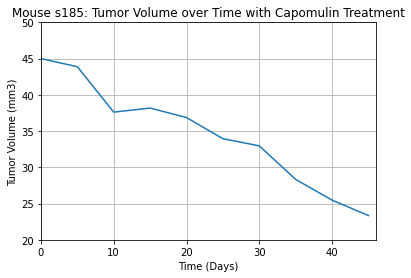

In [17]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
time_point = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
tumor = [45.000000, 43.878496, 37.614948, 38.177232, 36.866876, 33.949940, 32.959671, 28.328531, 25.472143, 23.343598]
plt.plot(time_point, tumor)
plt.title("Mouse s185: Tumor Volume over Time with Capomulin Treatment")
plt.xlabel("Time (Days)")
plt.ylabel("Tumor Volume (mm3)")
plt.xlim(0,46)
plt.ylim(20, 50)
plt.grid()
plt.show()

In [18]:
# Make a new dataframe for mice treated with Capomulin and generate average tumor volume
capo_mouse = mousedata_clean.loc[mousedata_clean["Drug Regimen"] == "Capomulin"]
capo_mouse = capo_mouse.groupby(["Mouse ID","Drug Regimen"])
capo_mean = capo_mouse.mean()
average_tumor_volume = capo_mean.head(50)
average_tumor_volume

,,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
Mouse ID,Drug Regimen,,,,,
b128,Capomulin,9.0,22.0,22.5,41.963636,0.70
b742,Capomulin,7.0,21.0,22.5,40.083699,0.00
f966,Capomulin,16.0,17.0,10.0,36.505973,0.00
g288,Capomulin,3.0,19.0,22.5,41.990097,0.80
g316,Capomulin,22.0,22.0,22.5,44.613344,1.00
i557,Capomulin,1.0,24.0,22.5,44.805810,0.20
i738,Capomulin,23.0,20.0,22.5,39.141053,0.60
j119,Capomulin,7.0,23.0,22.5,44.465236,0.60
j246,Capomulin,21.0,21.0,17.5,43.216925,0.25


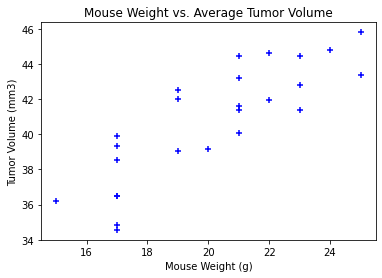

In [19]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
weight = average_tumor_volume["Weight (g)"]
tumor = average_tumor_volume["Tumor Volume (mm3)"]
plt.scatter(weight, tumor, marker="+", facecolors="blue")
plt.title("Mouse Weight vs. Average Tumor Volume")
plt.xlabel("Mouse Weight (g)")
plt.ylabel("Tumor Volume (mm3)")
plt.show()

## Correlation and Regression

The r-squared is: 0.7088568047708717


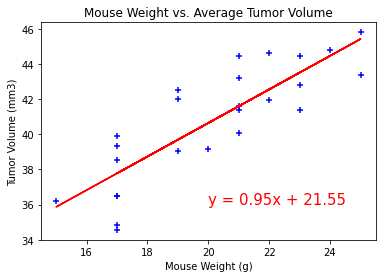

In [20]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
(slope, intercept, rvalue, pvalue, stderr) = linregress(weight, tumor)
regress_values = weight * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(weight, tumor, marker="+", facecolors="blue")
plt.title("Mouse Weight vs. Average Tumor Volume")
plt.xlabel("Mouse Weight (g)")
plt.ylabel("Tumor Volume (mm3)")
plt.plot(weight,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")
plt.show()